In [30]:
import sys
sys.path.append("..")

from generators.random_forest_generator import RFGenerator
from generators.p4_code_generator import P4CodeGenerator

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os, glob

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import minmax_scale
from sklearn.utils import shuffle
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree
from sklearn.tree import _tree

# parameter setting
flow_length = 7
relevant_features_num = 20

dataset_tues_sliced_path = f"../../../datasets/Tuesday-WorkingHours_sliced_flow_{flow_length}_preprocessed.csv"
feature_scores_balanced_equal_path = f"../../outputs/feature_importance/balanced/balanced_equal_{flow_length}/feature_scores_balanced_equal_{flow_length}.csv"
p4_code_single_file_path = f"../../outputs/p4_code/single_file/"

rf_gen = RFGenerator()

Start building Random Forest


In [31]:
# get the relevant features
feature_scores_df = pd.read_csv(feature_scores_balanced_equal_path, index_col=0)
relevant_features = feature_scores_df.iloc[:relevant_features_num, :]

# read the preprocessed data
df = pd.read_csv(dataset_tues_sliced_path)

print(f"original size: {len(df)}")

# extract flows with 7 bidirectional pacekts
df = df[df["bidirectional_packets"] == 7]
print(f"7 pkts size: {len(df)}")

# get the benign and attack dataset
df_benign = df[df["Label"] == 0]
df_attack = df[df["Label"] == 1]
# the number of attack flows is less than the number of benign flows without duplicates
attack_num = len(df_attack)
# cut the replicated flow entries for benign
df_benign_no_dup = df_benign[df_benign.duplicated(
    keep='first').map({True: False, False: True})]
# set drop=True to remove the orignal index after sampling
df_benign_no_dup = df_benign_no_dup.sample(
    attack_num).reset_index(drop=True)
# concatenate df_benign_no_dup and df_attack and shuffle them
df = pd.concat([df_benign_no_dup, df_attack])
df = shuffle(df)

print(f"attack num: {attack_num}")
print(f"balanced size: {len(df)}")

# save data of the relevant features
relevant_features_index = relevant_features.index.tolist()
df = df[relevant_features_index + ["Label"]]
df = shuffle(df)

original size: 308349
7 pkts size: 107915
attack num: 6950
balanced size: 13900


In [15]:
relevant_features_index

['splt_piat_ms_2',
 'bidirectional_mean_ps',
 'dst2src_mean_ps',
 'dst2src_max_ps',
 'bidirectional_max_ps',
 'dst2src_bytes',
 'bidirectional_bytes',
 'splt_piat_ms_5',
 'splt_ps_4',
 'src2dst_mean_ps',
 'src2dst_bytes',
 'splt_ps_6',
 'splt_ps_7',
 'src2dst_max_ps',
 'src2dst_duration_ms',
 'src2dst_mean_piat_ms',
 'splt_piat_ms_6',
 'src2dst_max_piat_ms',
 'splt_piat_ms_3',
 'bidirectional_max_piat_ms']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1],
                                                    df.iloc[:, -1],
                                                    test_size=0.3,
                                                    random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (9730, 20)
y_train shape: (9730,)
X_test shape: (4170, 20)
y_test shape: (4170,)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2061
           1       1.00      1.00      1.00      2109

    accuracy                           1.00      4170
   macro avg       1.00      1.00      1.00      4170
weighted avg       1.00      1.00      1.00      4170



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


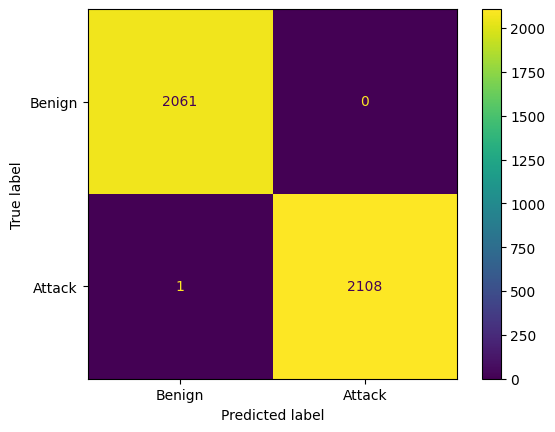

In [33]:
# train the rf estimater (best parameters: 3 trees, 5 maximum depth)
n_estimators = 3
max_depth = 5

rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)

rf = rf.fit(X_train, y_train)


# show the evaluation
y_predict = rf.predict(X_test)
print(classification_report(y_test, y_predict))
plot_confusion_matrix(rf, X_test, y_test, display_labels=["Benign", "Attack"])

In [34]:
# generate P4 code

feature_compatible_serialiazation_path = "../../outputs/serialization/feature_compatible_serialized.pkl"
feature_list_path = "../../dataset/features_with_id.csv"

# get the compatible features from pkl

with open(feature_compatible_serialiazation_path, "rb") as f:
    features_compatible = pickle.load(f)

p4_gen = P4CodeGenerator(rf_estimator=rf, 
                         full_features=features_compatible, 
                         relevant_features=relevant_features_index, 
                         save_path=p4_code_single_file_path, 
                         features_path=feature_list_path)
    
p4_gen.generate_p4_rules(packets_count=7)
# p4_gen.generate_bitstring_to_struct_action()
# p4_gen.generate_compare_feature_action()
# p4_gen.generate_mathch_action_tables()
# p4_gen.generate_classfication_logic()

P4 code generator
Generated P4 rules.


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


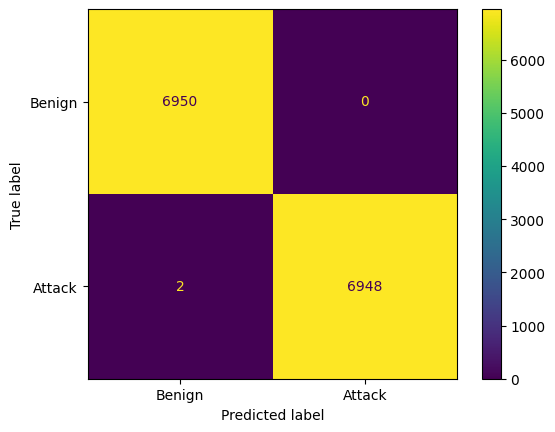

In [35]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

plot_confusion_matrix(rf, X, y, display_labels=["Benign", "Attack"])